# Research Question

In a previous research project[1] we determined that the largest contributer by far to a patient's readmission within 30 days of discharge is the length of their original stay in the hospital, defined in our dataset as ``Initial_days``. 

Our **question** is this: can we use clustering to find correlation between an attribute of a patient and their initial days? The goal here is to predict what patients are at risk of spending a long time in the hospital.

# Technique Justification: KMeans

We will be using KMeans clustering for this analysis. 

## How it works

K-means divides the data into *K* clusters by minimizing the sum of the squared distances of each record to the *mean* of the assigned cluster.[2] The number of clusters, *K*, is pre-defined by the user.  

The algorithm starts by randomly assigning all data points to a cluster then finding the means of those clusters. Then the following 2 steps occur:

1. Assign each record to the nearest cluster mean as measured by squared distance.
2. Computer the new cluster means based on the assignment of records.

These steps repeat until the assignment of records to clusters does not change, meaning the algorithm has converged.[3]

KMeans assumes that the data is numeric. Categorical variables will not work properly. KMeans is also most effective on normalized data.

## Tools

For this analysis we'll be using the ``KMeans`` function from the sci-kit learn library. Sci-kit provides an effective and user-friendly method of applying KMeans to a dataset. 

# Data Preparation

We will not be able to complete the analysis on the data in it's current form. Our **goals** are: 

1. Remove uneeded data
2. Normalize the remaining data so that KMeans will be the most effective

## Initial Data Import

We know from a previous analysis[1] that the most relevant variables that predict reamission are:

- Initial_days
- Age
- Income
- Population
- VidD_levels
- Full_meals_eaten

So, we will first reduce the data to only those variables.

In [16]:
#!pip install -r requirements.txt

import pandas as pd

raw = pd.read_csv('data/medical_clean.csv')
df = raw[[
    'Initial_days', 
    'Age', 
    'Income', 
    'Population', 
    'VitD_levels', 
    'Full_meals_eaten', 
    ]]

df.head()

,Initial_days,Age,Income,Population,VitD_levels,Full_meals_eaten
0,10.585770,53,86575.93,2951,19.141466,0
1,15.129562,51,46805.99,11303,18.940352,2
2,4.772177,53,14370.14,17125,18.057507,1
3,1.714879,78,39741.49,2162,16.576858,1
4,1.254807,22,1209.56,5287,17.439069,0


## Normalization

Now we normalize the data and save our new dataset to ``medial_normalized.csv``

In [17]:
df = ((df - df.min()) / (df.max() - df.min())).round(2)
df.to_csv('data/medical_normalized.csv')
df.head()

,Initial_days,Age,Income,Population,VitD_levels,Full_meals_eaten
0,0.14,0.49,0.42,0.02,0.56,0.00
1,0.20,0.46,0.23,0.09,0.55,0.29
2,0.05,0.49,0.07,0.14,0.50,0.14
3,0.01,0.85,0.19,0.02,0.41,0.14
4,0.00,0.06,0.01,0.04,0.46,0.00


# Analysis

## Finding our K value
Before we can begin our true analysis we must determine the number of *K* clusters to use. We will run a test using a range of clusters from 2 to 14 to see where we can get the most explained variance with the fewest clusters.

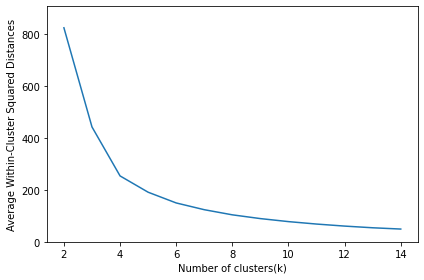

In [18]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import random

# Run kmeans from 2-15 clusters
inertia = []
for n_clusters in range(2, 15):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(df)
    inertia.append(kmeans.inertia_ / n_clusters)

inertias = pd.DataFrame({'n_clusters': range(2, 15), 'inertia': inertia})
ax = inertias.plot(x='n_clusters', y='inertia')

# graph the results
plt.xlabel('Number of clusters(k)')
plt.ylabel('Average Within-Cluster Squared Distances')
plt.ylim((0, 1.1 * inertias.inertia.max()))
ax.legend().set_visible(False)
plt.tight_layout()
plt.show()

By looking at the graph, we see that we get a well-defined elbow at 4 clusters. Meaning that after 4 clusters we get diminishing returns. Therefore, we will choose a *K* of 4.

## Analysis

We will run our KMeans with 4 clusters and count the number of entries in each cluster.

In [19]:
# run the algorithm
kmeans = KMeans(n_clusters=4, random_state=0).fit(df)

# Count the clusters
from collections import Counter
print(Counter(kmeans.labels_))

Counter({3: 2516, 2: 2507, 0: 2495, 1: 2482})


To gain additional Insight we will create a chart of each cluster.

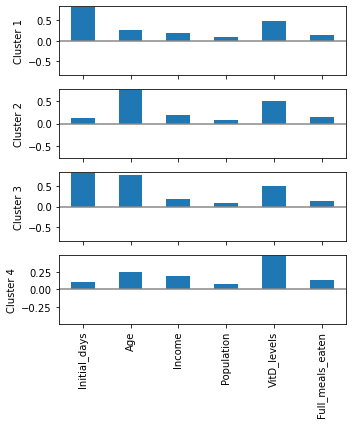

In [20]:
import numpy as np

centers = pd.DataFrame(kmeans.cluster_centers_, columns=df.columns)

# page 300 in practical statistics
f, axes = plt.subplots(4, 1, figsize=(5, 6), sharex=True)
for i, ax in enumerate(axes):
    center = centers.loc[i, :]
    maxPC = 1.01 * np.max(np.max(np.abs(center)))
    colors = ['C0' if l > 0 else 'C1' for l in center]
    ax.axhline(color='#888888')
    center.plot.bar(ax=ax, color=colors)
    ax.set_ylabel(f'Cluster {i + 1}')
    ax.set_ylim(-maxPC, maxPC)

plt.tight_layout()
plt.show()

# Summary and Implications.

Unfortunately our analysis is inconclusive. The result of our KMeans clustering has yielded clusters that contradict each other. We have clusters with high ``initial_days`` and high ``Age``, but we also have clusters with low ``initial_days`` and high ``Age``. No other variable changes significantly between clusters. Our analysis has been limited by a dataset that has no obvious correlations. 

Due to the limited nature of this analysis no recommendations can be made. The organization should find a better dataset to work with.

# Bibliography

[1] Curtis Hammons. *Logistic Regression on Medical Data*. https://github.com/cjhammons/Logistic-Regression-on-Medical-Data. Accessed 4 Feb 2022.

[2] Peter Bruce, Andrew Bruce, Peter Gedeck. *Practical Statistics for Data Scientists*. O'Reilly Media, Inc., 2020. Page 295. 

[3] Peter Bruce, Andrew Bruce, Peter Gedeck. *Practical Statistics for Data Scientists*. O'Reilly Media, Inc., 2020. Page 298. 